In [1]:
import pandas as pd
import numpy as np
from importlib import reload
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm, chi2
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pdaactconn as pc
from trialexplorer import AACTStudySet
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/akhazan/.virtualenvs/notebooks_venv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("results_first_submitted_date is not null")
ss.add_constraint("enrollment_type = 'Actual'")
ss.add_constraint("enrollment >= 10")
ss.add_constraint("enrollment <= 500")
ss.add_constraint("phase = 'Phase 2'")
ss.load_studies()

8782 studies loaded!


In [3]:
ss.add_dimensions(['baseline_measurements', 'result_groups', 'outcomes', 'outcome_measurements', 'outcome_counts', 'outcome_analyses',
                  'designs'])
ss.refresh_dim_data()
rg = ss.dimensions['result_groups']
bm = ss.dimensions['baseline_measurements']
om = ss.dimensions['outcome_measurements']
oa = ss.dimensions['outcome_analyses']
oc = ss.dimensions['outcome_counts']
out = ss.dimensions['outcomes']
des = ss.dimensions['designs']

Successfuly added these 7 dimensions: ['baseline_measurements', 'result_groups', 'outcomes', 'outcome_measurements', 'outcome_counts', 'outcome_analyses', 'designs']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 18 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_analyses
 -- Loading raw data
 -- Sorting index
 - Loading dimension designs
 -- Loading raw data
 -- Sorting index


In [4]:
des.data.allocation.value_counts(dropna=False)
des.data.allocation.fillna('Missing', inplace=True)

In [5]:
#Get studies with exactly two treatment groups besides "Total" and grab necessary columns
combined_measures = pd.merge(rg.data, bm.data, left_on = ['nct_id', 'id'], right_on = ['nct_id', 'result_group_id'])
combined_measures = combined_measures[combined_measures.title_x != 'Total']
num_groups = combined_measures.groupby('nct_id').ctgov_group_code_x.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
combined_measures = combined_measures.merge(num_groups, on=['nct_id'])
combined_measures = combined_measures[combined_measures.n_groups==2]
#Limit to randomized studies
combined_measures = combined_measures.merge(des.data, on = 'nct_id')
combined_measures = combined_measures[combined_measures.allocation == 'Randomized']
study_balance_dat = combined_measures[['ctgov_group_code_x', 'classification', 'category', 'title_y',
                                       'param_type', 'param_value_num',
                                       'dispersion_type', 'dispersion_value_num']]

In [6]:
study_balance_dat.title_y.value_counts().head(10)
#We'll go with age and sex for now

Age                                                             10050
Sex: Female, Male                                                9924
Race (NIH/OMB)                                                   9198
Region of Enrollment                                             4320
Race/Ethnicity, Customized                                       3052
Ethnicity (NIH/OMB)                                              2844
Age, Customized                                                  1230
Gender                                                            348
Eastern Cooperative Oncology Group (ECOG) Performance Status      178
Weight                                                            128
Name: title_y, dtype: int64

In [7]:
sb_age = study_balance_dat[study_balance_dat.title_y == 'Age']
sb_age_cat = sb_age[sb_age.param_type=='Count of Participants']
sb_age_con = sb_age[sb_age.param_type=='Mean']
print(sb_age_cat.index.nunique())
print(sb_age_con.index.nunique())
#We'll choose the continuous version for now, since it has more

915
1935


In [8]:
#Sex is always a count variable; only variability is capitalization of "category" field
#Get rid of rows that aren't sex or age
age_condition1 = study_balance_dat.title_y == 'Age'
age_condition2 = study_balance_dat.param_type == 'Mean'
sex_condition = study_balance_dat.title_y == 'Sex: Female, Male'
full_condition = (age_condition1 & age_condition2) | sex_condition
small_balance_dat = study_balance_dat[full_condition]
small_balance_dat.head(20)

,ctgov_group_code_x,classification,category,title_y,param_type,param_value_num,dispersion_type,dispersion_value_num
nct_id,,,,,,,,
NCT00000392,B2,,Male,"Sex: Female, Male",Count of Participants,104.00,,NaN
NCT00000392,B2,,Female,"Sex: Female, Male",Count of Participants,5.00,,NaN
NCT00000392,B1,,Male,"Sex: Female, Male",Count of Participants,101.00,,NaN
NCT00000392,B1,,Female,"Sex: Female, Male",Count of Participants,5.00,,NaN
NCT00001304,B2,,Male,"Sex: Female, Male",Count of Participants,4.00,,NaN
NCT00001304,B2,,Female,"Sex: Female, Male",Count of Participants,10.00,,NaN
NCT00001304,B1,,Male,"Sex: Female, Male",Count of Participants,6.00,,NaN
NCT00001304,B1,,Female,"Sex: Female, Male",Count of Participants,7.00,,NaN
NCT00001586,B2,,Male,"Sex: Female, Male",Count of Participants,35.00,,NaN


In [9]:
#get studies that have both measures we're using
num_measures = small_balance_dat.groupby('nct_id').title_y.nunique()
num_measures = pd.DataFrame(num_measures)
num_measures.columns.values[0] = 'n_measures'
small_balance_dat = small_balance_dat.merge(num_measures, on=['nct_id'])
small_balance_dat = small_balance_dat[small_balance_dat.n_measures==2]

#assert that each study has 6 rows now--2 sex and 1 age for each of the 2 arms
num_rows = small_balance_dat.groupby('nct_id').title_y.count()
num_rows = pd.DataFrame(num_rows)
num_rows.columns.values[0] = 'n_rows'
small_balance_dat = small_balance_dat.merge(num_rows, on=['nct_id'])
small_balance_dat = small_balance_dat[small_balance_dat.n_rows == 6]

In [10]:
#handle aforementioned capitalization issue
small_balance_dat.category = small_balance_dat.category.str.lower()
small_balance_dat.head()

,ctgov_group_code_x,classification,category,title_y,param_type,param_value_num,dispersion_type,dispersion_value_num,n_measures,n_rows
nct_id,,,,,,,,,,
NCT00001586,B2,,male,"Sex: Female, Male",Count of Participants,35.00,,NaN,2,6
NCT00001586,B2,,female,"Sex: Female, Male",Count of Participants,21.00,,NaN,2,6
NCT00001586,B2,,,Age,Mean,58.42,Standard Deviation,11.32,2,6
NCT00001586,B1,,male,"Sex: Female, Male",Count of Participants,30.00,,NaN,2,6
NCT00001586,B1,,female,"Sex: Female, Male",Count of Participants,19.00,,NaN,2,6


In [11]:
def calculate_imbalance(study_frame):
    nctid = study_frame.index[0]
    group_codes = study_frame.ctgov_group_code_x.unique()
    group1 = study_frame[study_frame.ctgov_group_code_x == group_codes[0]]
    group2 = study_frame[study_frame.ctgov_group_code_x == group_codes[1]]
    
    sex_imbalance, group_size_imbalance = calculate_sex_imbalance(group1, group2)
    age_imbalance = calculate_age_imbalance(group1, group2)
    
    return([nctid, sex_imbalance, age_imbalance, group_size_imbalance])

def calculate_sex_imbalance(arm1, arm2):
    arm1_sex = arm1[arm1.title_y == 'Sex: Female, Male']
    arm2_sex = arm2[arm2.title_y == 'Sex: Female, Male']
    
    arm1_size = arm1_sex.param_value_num.sum()
    arm2_size = arm2_sex.param_value_num.sum()
    
    arm1_men = arm1_sex[arm1_sex.category == 'male'].param_value_num[0]
    arm2_men = arm2_sex[arm2_sex.category == 'male'].param_value_num[0]
    
    arm1_pct_men = arm1_men / arm1_size
    arm2_pct_men = arm2_men / arm2_size
    
    sex_imbalance = abs(arm1_pct_men - arm2_pct_men)
    group_size_imbalance = abs(0.5 - (arm1_size) / (arm1_size + arm2_size))
    return((sex_imbalance, group_size_imbalance))

def calculate_age_imbalance(arm1, arm2):
    arm1_mean_age = arm1[arm1.title_y == 'Age'].param_value_num[0]
    arm2_mean_age = arm2[arm2.title_y == 'Age'].param_value_num[0]
    
    age_imbalance = 12 * abs(arm1_mean_age - arm2_mean_age) 
    return(age_imbalance)

In [12]:
#Time to calculate imbalances
imbalance_dat = []
study_ids = small_balance_dat.index.unique()
n_studies = study_ids.shape[0]
print('Calculating imbalance for ' + str(n_studies) + ' studies')
for i in range(n_studies):
    current_id = study_ids[i]
    current_study = small_balance_dat[small_balance_dat.index == current_id]
    current_imbalances = calculate_imbalance(current_study)
    imbalance_dat.append(current_imbalances)
    if (i + 1) % 1000 == 0:
        print('Finished with ' + str(i + 1) + ' studies.')
imbalance_frame = pd.DataFrame(imbalance_dat, columns = ['nct_id', 'sex_imbalance', 'age_imbalance', 'group_size_imbalance'])
imbalance_frame.head()

Calculating imbalance for 1841 studies
Finished with 1000 studies.


,nct_id,sex_imbalance,age_imbalance,group_size_imbalance
0,NCT00001586,0.012755,26.64,0.033333
1,NCT00001596,0.152174,53.28,0.157143
2,NCT00001723,0.010000,1.56,0.000000
3,NCT00003222,0.217033,24.00,0.182927
4,NCT00004980,0.014493,4.80,0.040000


In [13]:
om.data.reset_index(inplace=True)
out.data.reset_index(inplace=True)
rg.data.reset_index(inplace=True)
oa.data.reset_index(inplace=True)
oc.data.reset_index(inplace=True)
out.data = out.data.add_prefix('out_')
om.data = om.data.add_prefix('om_')
rg.data = rg.data.add_prefix('rg_')
oa.data = oa.data.add_prefix('oa_')
oc.data = oc.data.add_prefix('oc_')

In [14]:
combined_outcomes = om.data.merge(out.data, left_on = ['om_nct_id', 'om_outcome_id'], 
                                  right_on = ['out_nct_id', 'out_id'])

combined_outcomes = combined_outcomes.merge(rg.data, left_on = ['om_nct_id','om_result_group_id'], 
                                            right_on = ['rg_nct_id','rg_id'])
primary_outcomes = combined_outcomes[combined_outcomes.out_outcome_type == 'Primary']

In [15]:
num_groups = primary_outcomes.groupby(['om_nct_id', 'om_outcome_id']).om_result_group_id.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
primary_outcomes = primary_outcomes.merge(num_groups, on=['om_nct_id', 'om_outcome_id'])
primary_outcomes = primary_outcomes[primary_outcomes.n_groups==2]

In [16]:
primary_outcomes = primary_outcomes.merge(
    oc.data.drop_duplicates(subset=['oc_nct_id', 'oc_result_group_id', 'oc_outcome_id'], keep='first'), 
    left_on=['om_nct_id', 'om_result_group_id', 'om_outcome_id'], right_on=['oc_nct_id', 'oc_result_group_id', 'oc_outcome_id'])

In [17]:
primary_outcomes.groupby(['om_param_type', 'om_dispersion_type']).agg({'om_nct_id':'nunique'}).sort_values(by='om_nct_id', ascending=False).head(10)

,,om_nct_id
om_param_type,om_dispersion_type,
Number,,983
Mean,Standard Deviation,890
Count of Participants,,356
Number,95% Confidence Interval,296
Median,95% Confidence Interval,267
Least Squares Mean,Standard Error,169
Mean,Standard Error,162
Median,Inter-Quartile Range,114
Mean,95% Confidence Interval,91


In [18]:
primary_ids = primary_outcomes.om_nct_id.unique()

In [171]:
study_values = []
for pid in primary_ids:
    temp_frame = primary_outcomes[primary_outcomes.om_nct_id == pid]
    temp_outcome_ids = temp_frame.om_outcome_id.unique()
    sampled_index = np.random.choice(temp_outcome_ids.shape[0], 1, replace=False)
    chosen_outcome = temp_frame[temp_frame.om_outcome_id == temp_outcome_ids[sampled_index][0]].reset_index()
    chosen_param_type = chosen_outcome.om_param_atype
    chosen_params = chosen_outcome.om_param_value_num
    chosen_dispersion_type = chosen_outcome.om_dispersion_type
    chosen_dispersions = chosen_outcome.om_dispersion_value_num
    chosen_dispersions_lower = chosen_outcome.om_dispersion_lower_limit
    chosen_dispersions_upper = chosen_outcome.om_dispersion_upper_limit
    chosen_n = chosen_outcome.oc_count
    study_values.append(
        [pid, chosen_outcome['om_result_group_id'][0], chosen_outcome['om_outcome_id'][0], chosen_n[0], chosen_n[1], chosen_param_type[0], 
         chosen_params[0], chosen_params[1], chosen_dispersion_type[0], chosen_dispersions[0], chosen_dispersions[1],
        chosen_dispersions_lower[0], chosen_dispersions_upper[0], chosen_dispersions_lower[1], chosen_dispersions_upper[1]])
study_values = pd.DataFrame(study_values, columns = ['nct_id', 'result_group_id', 'outcome_id', 'n1', 'n2', 'param_type', 'param1', 'param2', 
    'dispersion_type', 'dispersion1', 'dispersion2', 'dispersion1_lower', 'dispersion1_upper', 'dispersion2_lower', 'dispersion2_upper'])
study_values.shape

(3329, 15)

In [172]:
oa_per_outcome = oa.data.groupby(['oa_outcome_id']).agg({'oa_nct_id':'count'}).reset_index()
single_oa_per_outcome = oa_per_outcome[oa_per_outcome.oa_nct_id==1]['oa_outcome_id']

In [173]:
#Only include studies with a single outcome analysis per outcome or no outcome analysis posted at all, drops ~200 studies

study_values = study_values[study_values.outcome_id.isin(single_oa_per_outcome)|(~study_values.outcome_id.isin(oa.data.oa_outcome_id))]\
    .merge(oa.data.set_index('oa_outcome_id')[['oa_non_inferiority_type', 'oa_p_value', 'oa_method']], left_on=['outcome_id'], right_index=True, how='left')
study_values.shape

(3173, 18)

In [174]:
#Leaving only studies with reported p_values in single outcome_analysis
# study_values = study_values[study_values['oa_p_value'].notnull()]
# study_values.shape

In [387]:
study_values[(study_values.oa_method!='')&(study_values.oa_method.notnull())].shape

(947, 25)

In [392]:
study_values[(study_values.oa_method!='')&(study_values.oa_method.notnull())].groupby(['oa_method']).agg({'nct_id':'nunique'}).reset_index().sort_values(by='nct_id', ascending=False).head(9)
#Log Rank: We don't have the full survival curve, and therefore cannot calculate expected data per study arm (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC403858/)
#ANCOVA: We don't have enough data on the control variable to perform this test
#Wilcoxon (Mann-Whitney): we don't have the full data distribution to complete http://tqmp.org/RegularArticles/vol04-1/p013/p013.pdf
#Mixed Models Analysis: not enough data

,oa_method,nct_id
10,ANCOVA,145
61,Log Rank,99
161,"t-test, 2 sided",87
81,Mixed Models Analysis,82
38,Fisher Exact,77
135,Wilcoxon (Mann-Whitney),70
21,Chi-squared,61
11,ANOVA,48
25,Cochran-Mantel-Haenszel,31


In [176]:
def compute_t_stat(row):
    
    n1 = float(row['n1'])
    n2 = float(row['n2'])
    
    if row['param_type']=='Mean' and row['dispersion_type']=='Standard Deviation':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=float(row['dispersion1'])
        std2=float(row['dispersion2'])
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)
    
    if row['param_type']=='Mean' and row['dispersion_type']=='Standard Error':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=float(row['dispersion1'])*np.sqrt(n1)
        std2=float(row['dispersion2'])*np.sqrt(n2)
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)
    
    if row['param_type']=='Mean' and row['dispersion_type']=='95% Confidence Interval':
        mean1=float(row['param1'])
        mean2=float(row['param2'])
        std1=np.sqrt(n1)*(float(row['dispersion1_upper']) - float(row['dispersion1_lower'])) / 3.92
        std2=np.sqrt(n2)*(float(row['dispersion2_upper']) - float(row['dispersion2_lower'])) / 3.92
        
        if n1*n2!=0 and std1*std2!=0:
            return (mean1-mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)

In [307]:
def compute_t_stat_p_val(row):
    return 1 - norm.cdf(row['computed_t_stat'])

In [179]:
# Start with t-test, 2 sided

study_values['computed_t_stat'] = study_values.apply(compute_t_stat, axis=1)

In [308]:
study_values['computed_t_stat_p_val'] = study_values.apply(compute_t_stat_p_val, axis=1)

(0, 1)

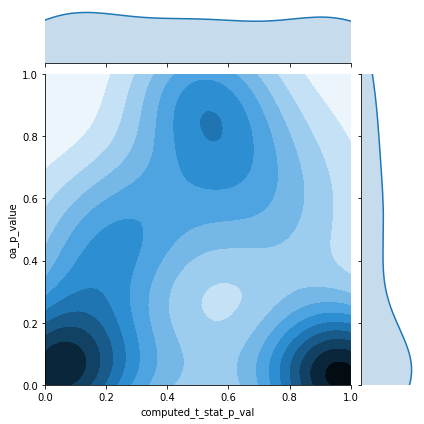

In [309]:
#Comparing 1-sided t-test computed from mean and variance of the data and the reported '2-sided t-test'
#reveals 3 clusters: lower left where both findings are significant, upper middle where both are not significant,
#and the lower right where 1-sided computed is entirely not significant and reported is 2-sided significant. 

ax = sns.jointplot(
    x='computed_t_stat_p_val', 
    y='oa_p_value', 
    data=study_values[(study_values.oa_method=='t-test, 2 sided')
                      &(study_values.param_type=='Mean')
                      &(study_values.dispersion_type.isin(['Standard Deviation', '95% Confidence Interval', 'Standard Error']))],
kind='kde')

ax.ax_marg_x.set_xlim(0, 1)
ax.ax_marg_y.set_ylim(0, 1)

In [318]:
#Calculating ratio of computed and reported p values

study_values.loc[(study_values['oa_method']=='t-test, 2 sided')
        &(study_values['computed_t_stat_p_val']>0)
        &(study_values['computed_t_stat_p_val']<=1)
        &(study_values['oa_p_value']>0)
        &(study_values['oa_p_value']<=1)
    , 't_stat_p_val_ratio'] = study_values['oa_p_value']/study_values['computed_t_stat_p_val']

study_values['t_stat_p_val_ratio'] = pd.to_numeric(study_values['t_stat_p_val_ratio'])

In [397]:
study_values[(study_values.computed_t_stat_p_val.notnull())&(study_values.oa_method=='t-test, 2 sided')].shape

(73, 25)

In [386]:
study_values[study_values['t_stat_p_val_ratio'].notnull()].sort_values(by='t_stat_p_val_ratio')

,nct_id,result_group_id,outcome_id,n1,n2,param_type,param1,param2,dispersion_type,dispersion1,...,oa_non_inferiority_type,oa_p_value,oa_method,computed_t_stat,computed_t_stat_p_val,computed_chi2,computed_chi2_p_val,computed_fe_odds_ratio,computed_fe_p_val,t_stat_p_val_ratio
228,NCT00165841,976352,293572,91,96,Mean,62.1700,82.580,Standard Deviation,29.9300,...,Superiority or Other,0.0001,"t-test, 2 sided",-5.891611,1.000000e+00,NaN,NaN,NaN,NaN,0.000100
1382,NCT00872430,681782,204256,20,20,Mean,15.6600,42.300,Standard Deviation,9.7100,...,Superiority or Other,0.0010,"t-test, 2 sided",-5.616307,1.000000e+00,NaN,NaN,NaN,NaN,0.001000
441,NCT00350402,923350,277312,20,20,Mean,-1.6050,5.649,Standard Deviation,6.1600,...,Superiority or Other,0.0010,"t-test, 2 sided",-3.575934,9.998255e-01,NaN,NaN,NaN,NaN,0.001000
2954,NCT02262078,171880,51984,13,13,Mean,-4.0000,-1.000,Standard Deviation,3.0000,...,Superiority or Other,0.0020,"t-test, 2 sided",-3.000000,9.986501e-01,NaN,NaN,NaN,NaN,0.002003
835,NCT00558753,827537,247766,70,76,Mean,5.7700,6.400,Standard Deviation,1.3100,...,Superiority or Other,0.0030,"t-test, 2 sided",-2.956568,9.984446e-01,NaN,NaN,NaN,NaN,0.003005
3114,NCT02514044,111648,33971,10,10,Mean,-4.2000,11.020,95% Confidence Interval,NaN,...,Other,0.0080,"t-test, 2 sided",-2.954971,9.984365e-01,NaN,NaN,NaN,NaN,0.008013
350,NCT00283387,949201,285191,10,10,Mean,1.0400,1.430,Standard Deviation,0.7100,...,Superiority or Other,0.0070,"t-test, 2 sided",-1.025961,8.475449e-01,NaN,NaN,NaN,NaN,0.008259
1192,NCT00759772,737013,220813,11,12,Mean,0.2000,5.600,Standard Error,0.7000,...,Superiority,0.0100,"t-test, 2 sided",-3.657341,9.998726e-01,NaN,NaN,NaN,NaN,0.010001
503,NCT00386425,907893,272433,206,206,Mean,31.0000,83.000,Standard Deviation,29.0000,...,Superiority or Other,0.0110,"t-test, 2 sided",-16.419949,1.000000e+00,NaN,NaN,NaN,NaN,0.011000
68,NCT00064792,1008833,303709,18,18,Mean,93.9900,90.820,Standard Deviation,5.3600,...,Superiority or Other,0.0020,"t-test, 2 sided",1.336128,9.075379e-02,NaN,NaN,NaN,NaN,0.022038


In [363]:
study_values[(study_values['oa_method']=='t-test, 2 sided')
        &(study_values['computed_t_stat_p_val']>.00001)
        &(study_values['computed_t_stat_p_val']<=1)
        &(study_values['oa_p_value']>0)
        &(study_values['oa_p_value']<=1)]\
.groupby(['oa_non_inferiority_type']).agg({'t_stat_p_val_ratio':['count', 'mean', 'median', 'std']})

t_stat_p_val_ratio                        \
                                            count       mean     median   
oa_non_inferiority_type                                                   
Equivalence                                     2   8.147585   8.147585   
Non-Inferiority or Equivalence                  2  34.168947  34.168947   
Other                                           4   0.551070   0.482897   
Superiority                                    11   2.079268   1.109280   
Superiority or Other                           52   1.223376   0.978513   

                                           
                                      std  
oa_non_inferiority_type                    
Equivalence                      8.576691  
Non-Inferiority or Equivalence  47.609147  
Other                            0.607520  
Superiority                      3.838437  
Superiority or Other             1.312472

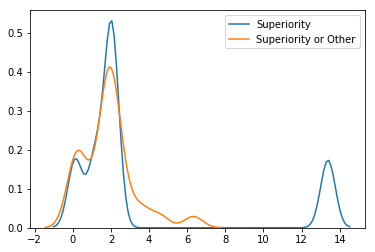

In [407]:
for test_type in ('Superiority', 'Superiority or Other'):
    ax = sns.distplot(study_values[(study_values['oa_method']=='t-test, 2 sided')
            &(study_values['computed_t_stat_p_val']>.000001)
            &(study_values['computed_t_stat_p_val']<=.5)
            &(study_values['oa_p_value']>0)
            &(study_values['oa_p_value']<=1)
            &(study_values['oa_non_inferiority_type']==test_type)
    ][['t_stat_p_val_ratio']], kde=True, hist=False, label=test_type)


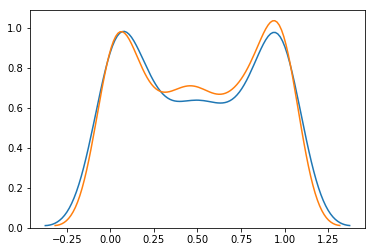

In [333]:
#Comparing 1-sided computed p value for reported and unreported results where test type is 2-sided t test. 

sns.distplot(study_values[
    (study_values.oa_p_value.notnull())
    &(study_values.computed_t_stat_p_val.notnull())
][['computed_t_stat_p_val']], kde=True, hist=False)

sns.distplot(study_values[
    (study_values.oa_p_value.isnull())
    &(study_values.computed_t_stat_p_val.notnull())
][['computed_t_stat_p_val']], kde=True, hist=False)

In [209]:
chi2_cont = {
    'NCT02762500':[[62*.11, 62*(1-.11)],[62*.19, 62*(1-.19)]],
    'NCT02748213':[[112*.71, 112*(1-.71)],[110*.73, 110*(1-.73)]],
    'NCT02701634':[[33*.727, 33*(1-.727)],[33*.727, 33*(1-.727)]],
    'NCT02638051':[[130*.777, 130*(1-.777)],[130*.638, 130*(1-.638)]],
    'NCT02467504':[[17*.765, 17*(1-.765)],[23*.565, 23*(1-.565)]],
    'NCT02423577':[[53*.962, 53*(1-.962)],[26*.22, 26*(1-.22)]],
    'NCT02401529':[[25, 25],[36, 14]],
    'NCT02301988':[[19*.158, 19*(1-.158)],[16*.125, 16*(1-.125)]],
    'NCT02294786':[[7, 30-7],[9, 32-9]],
    'NCT02230761':[[27, 60-27],[6, 30-6]],
    'NCT02227147':[[23*.7, 23*(1-.7)],[24*.29, 24*(1-.29)]],
    'NCT02019563':[[100*.93, 100*(1-.93)],[72*.92, 72*(1-.92)]],
    'NCT02016898':[[29, 50-29],[28, 45-28]],
    'NCT01998399':[[4, 12-4],[2, 13-2]],
    'NCT01988090':[[25, 21],[27, 20]],
    'NCT01902303':[[6, 14-6],[11, 23-11]],
    'NCT01835145':[[31*.355, 31*(1-.355)],[15*.267, 15*(1-.267)]],
    'NCT01703039':[[1, 6-1],[3, 7-3]],
    'NCT01680887':[[6, 80-6],[7, 76-7]],
    'NCT01569451':[[5, 26-5],[12, 27-12]],
    'NCT01514370':[[4, 40-4],[7, 40-7]],
    'NCT01451814':[[35*.4, 35*(1-.4)],[31*.258, 31*(1-.258)]],
    'NCT01088529':[[24, 44-24],[8, 22-8]],
    'NCT01041976':[[19, 42-19],[3, 42-3]],
    'NCT01040351':[[17, 54-17],[7, 53-7]],
    'NCT01015534':[[28*.786, 28*(1-.786)],[27*.481, 27*(1-.481)]],
    'NCT00071890':[[81*.73, 81*(1-.73)],[67*.55, 67*(1-.55)]],
    'NCT00076804':[[63, 104-63],[62, 104-62]],
    'NCT00091026':[[71*.21, 71*(1-.21)],[68*.21, 68*(1-.21)]],
    'NCT00107575':[[37, 119-37],[46, 117-46]],
    'NCT00149825':[[13*.615, 13*(1-.615)],[15*.333, 15*(1-.333)]],
    'NCT00166296':[[36, 53-36],[38, 54-38]],
    'NCT00217087':[[9,1],[6,0]],
    'NCT00218296':[[163*.2, 163*(1-.2)],[169*.11, 169*(1-.11)]],
    'NCT00316303':[[17, 21-17],[12, 16-12]],
    'NCT00319956':[[91*.76, 91*(1-.76)],[85*.84, 85*(1-.84)]],
    'NCT00346398':[[22, 25-22],[19, 25-19]],
    'NCT00424294':[[35*.3143, 35*(1-.3143)],[34*.3529, 34*(1-.3529)]],
    'NCT00454181':[[11, 36-11],[2, 12-2]],
    'NCT00523718':[[5, 19-5],[2, 18-2]],
    'NCT00531934':[[73*.712, 73*(1-.712)],[73*.808,  73*(1-.808)]],
    'NCT00576758':[[75*.333, 75*(1-.333)],[74*.446, 74*(1-.446)]],
    'NCT00595868':[[55, 107-55],[36, 111-36]],
    'NCT00741936':[[26, 34],[5, 55]],
    'NCT00774852':[[22, 66-22],[21, 68-21]],
    'NCT00850070':[[5, 23-5],[3, 23-3]],
    'NCT00856492':[[35, 98-35],[24, 113-24]],
    'NCT00860028':[[4, 15-4],[2, 15-2]],
    'NCT00861146':[[20, 105-20],[1, 46-1]],
    'NCT00861705':[[221*.6, 221*(1-.6)],[212*.46, 212*(1-.46)]],
    'NCT00887341':[[37*.297, 37*(1-.297)],[39*.179, 39*(1-.179)]],
    'NCT00888459':[[14, 30-14],[11, 30-11]],
    'NCT00967330':[[116*.7931, 116*(1-.7931)],[54*.4259, 54*(1-.4259)]],
    'NCT00983580':[[42*.595, 42*(1-.595)],[43*.581, 43*(1-.581)]],
}

In [210]:
for i in chi2_cont:
    chi2, p_val, dof, ex = stats.chi2_contingency(np.array(chi2_cont[i]), 
                                    correction=False)
    study_values.loc[study_values.nct_id==i, 'computed_chi2'] = chi2
    study_values.loc[study_values.nct_id==i, 'computed_chi2_p_val'] = p_val

(0, 1)

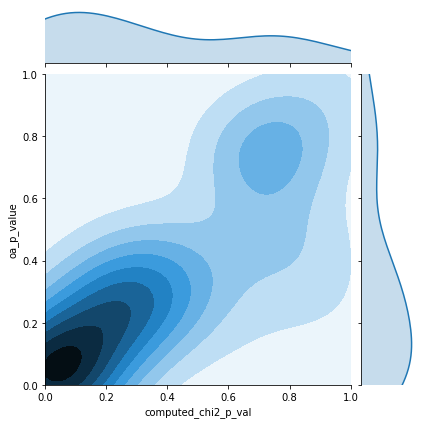

In [220]:
ax = sns.jointplot(
    x='computed_chi2_p_val', 
    y='oa_p_value', 
    data=study_values[(study_values.oa_method=='Chi-squared')&(study_values.computed_chi2_p_val.notnull())],
    kind='kde')

ax.ax_marg_x.set_xlim(0, 1)
ax.ax_marg_y.set_ylim(0, 1)

In [244]:
fe_cont = {
    'NCT00004412':[[25*.24, 25*(1-.24)],[37*.78, 37*(1-.78)]],
    'NCT00023309':[[15, 7],[6, 13]],
    'NCT00058019':[[14, 39-14],[0, 12-0]],
    'NCT00064025':[[8*.625, 8*(1-.625)],[45*.689, 45*(1-.689)]],
    'NCT00128180':[[30*.27, 30*(1-.27)],[30*.47, 30*(1-.47)]],
    'NCT00148109':[[3, 15-3],[1, 21-1]],
    'NCT00238238':[[45*.533,  45*(1-.533)],[46*.761, 46*(1-.761)]],
    'NCT00275561':[[9, 19-9],[6, 15-6]],
    'NCT00285779':[[14*.286, 14*(1-.286)],[0, 13]],
    'NCT00320541':[[94*.489, 94*(1-.489)],[92*.587, 92*(1-.587)]],
    'NCT00339040':[[96*.073, 96*(1-.073)],[30*.067, 30*(1-.067)]],
    'NCT00349466':[[32, 39-32],[19, 37-19]],
    'NCT00355394':[[5, 15-5],[12, 16-12]],
    'NCT00383331':[[2, 10],[0, 8]],
    'NCT00387127':[[12, 33-12],[18, 34-18]],
    'NCT00507507':[[64*.547, 64*(1-.547)],[62*.758, 62*(1-.758)]],
    'NCT00549640':[[1, 40-1],[4, 40-4]],
    'NCT00565448':[[1, 50-1],[0, 25-0]],
    'NCT00640146':[[18*.3333, 18*(1-.3333)],[0, 15]],
    'NCT00663117':[[20*.4, 20*(1-.4)],[20*.88, 20*(1-.88)]],
    'NCT00715962':[[0, 50],[2, 50-2]],
    'NCT00718094':[[10, 15-10],[0, 5-0]],
    'NCT00823082':[[100*.94, 100*(1-.94)],[94*.647, 94*(1-.647)]],
    'NCT00906204':[[13, 44-13],[12, 51-12]],
    'NCT00911300':[[3, 174-3],[2, 170-2]],
    'NCT00913744':[[74*.243, 74*(1-.243)],[25*.12, 25*(1-.12)]],
    'NCT00921557':[[5, 32-5],[2, 18-2]],
    'NCT00940901':[[2, 4-2],[3, 4-3]],
    'NCT00964496':[[20, 28-20],[1, 27-1]],
    'NCT00978120':[[103*.738, 103*(1-.738)],[99*.808, 99*(1-.808)]],
    'NCT00979212':[[22*.682, 22*(1-.682)],[39*.487, 39*(1-.487)]],
    'NCT00984022':[[6, 43-6],[19, 49-19]],
    'NCT00986362':[[16*.5, 16*(1-.5)],[8*.625, 8*(1-.625)]],
    'NCT01094548':[[8, 17-8],[7, 15-7]],
    'NCT01120236':[[42, 105-42],[34, 105-34]],
    'NCT01157117':[[28*.464, 28*(1-.464)],[29*.345, 29*(1-.345)]],
    'NCT01160640':[[14, 7],[18, 1]],
    'NCT01255163':[[5, 13-5],[0, 14]],
    'NCT01294319':[[0, 20],[1, 19-1]],
    'NCT01328249':[[54*.704, 54*(1-.704)],[25*.6, 25*(1-.6)]],
    'NCT01399593':[[5, 51-5],[7, 51-7]],
    'NCT01450137':[[17, 20-17],[4, 10-4]],
    'NCT01511978':[[0, 14],[13, 18-13]],
    'NCT01537432':[[23*.565, 23*(1-.565)],[0, 12]],
    'NCT01610596':[[36*.306, 36*(1-.306)],[0, 35]],
    'NCT01700985':[[23*.522, 23*(1-.522)],[0, 20]],
    'NCT01783821':[[6, 29-6], [16, 30-16]],
    'NCT01816594':[[21*.333, 21*(1-.333)],[21*.429, 21*(1-.429)]],
    'NCT01827358':[[62, 66-62],[3, 64-3]],
    'NCT01827787':[[45*.356, 45*(1-.356)],[38*.132, 38*(1-.132)]],
    'NCT01927419':[[72*.597, 72*(1-.597)],[37*10.8, 37*(1-.108)]],
    'NCT01953354':[[7*.571, 7*(1-.571)],[6*.5, 6*(1-.5)]],
    'NCT02059213':[[16, 20-16],[32, 40-32]],
    'NCT02221648':[[3, 19-3],[5, 18-5]],
    'NCT02268175':[[30, 50-30],[16, 25-16]],
    'NCT02273973':[[166*.018, 166*(1-.018)],[168*.006, 186*(1-.006)]],
    'NCT02363959':[[4, 10-4],[7, 10-7]],
    'NCT02368886':[[54*.43, 54*(1-.43)],[62*.26, 62*(1-.26)]],
    'NCT02419313':[[0, 30],[8, 30-8]],
    'NCT02709005':[[11, 64-11],[8, 32-8]],
    'NCT02731131':[[0, 6],[1, 6-1]]
}

In [245]:
for i in fe_cont:
    oddsratio, pval = stats.fisher_exact(fe_cont[i])
    study_values.loc[study_values.nct_id==i, 'computed_fe_odds_ratio'] = oddsratio
    study_values.loc[study_values.nct_id==i, 'computed_fe_p_val'] = pval

(0, 1)

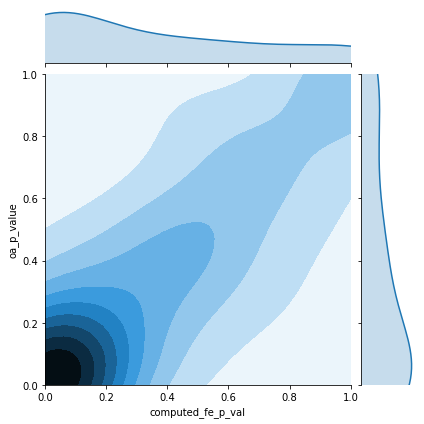

In [247]:
ax = sns.jointplot(
    x='computed_fe_p_val', 
    y='oa_p_value', 
    data=study_values[(study_values.oa_method=='Fisher Exact')&(study_values.computed_fe_p_val.notnull())],
    kind='kde')

ax.ax_marg_x.set_xlim(0, 1)
ax.ax_marg_y.set_ylim(0, 1)

In [266]:
study_values.groupby(['oa_non_inferiority_type', 'oa_method']).agg({'nct_id':'count'})

nct_id
oa_non_inferiority_type                 oa_method                                       
Equivalence                                                                            1
                                        ANOVA                                          1
                                        Fay - Shaw                                     1
                                        Regression, Cox                                1
                                        Wilcoxon (Mann-Whitney)                        1
                                        Wilcoxon sign-ranks test                       1
                                        t-test, 2 sided                                2
Non-Inferiority                                                                        3
                                        Cochran-Mantel-Haenszel                        1
                                        Log Rank                                       1
                                        Regression, Logistic                           1
                                        Wilcoxon (Mann-Whitney)                        1
                                        t-test, 1 sided                                2
Non-Inferiority or Equivalence                                                        14
                                        1-sided Wilcoxon Rank-Sum Test                 1
                                        2-sided 95% confidence interval                1
                                        2-sided 95% confidence interval calculat       1
                                        95% CI lower bound vs non-inf margin           1
                                        ANCOVA                                         1
                                        ANOVA                                          2
                                        Chi-squared                                    2
                                        Chi-squared, Corrected                         1
                                        Cochran-Mantel-Haenszel                        3
                                        Fisher Exact                                   1
                                        Mixed Models Analysis                          5
                                        t-test, 1 sided                                1
                                        t-test, 2 sided                                3
Non-Inferiority or Equivalence (legacy)                                                1
Other                                                                                 10
                                        ANCOVA                                         6
...                                                                                  ...
Superiority or Other                    constrained Longitudinal Data Analysis         1
                                        constrained longitudinal data analysis         1
                                        likelihood ratio of chi squared test           1
                                        likelihood-ratio chi square test               1
                                        log rank test                                  1
                                        log-binomial regression model                  1
                                        mixed effects regression models                1
                                        mixed effects/hierarchical linear model        1
                                        mixed model repeated measures (MMRM)           1
                                        mixed-model for repeated measures              1
                                        negative binomial regression                   1
                                        repeated measures model                        1
                                        stratified Cochran-Mantel-Haenszel te